# Feature Selecection

In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", message=".*use_label_encoder.*")

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

# Import Preporcessed Data

In [2]:
df = pd.read_csv("data/BTC-USD.csv")
df.set_index("Date" , inplace=True)

# Add prediction target

In [3]:
# Specify Target
df.loc[df["Range"].shift(-1) > df["AVG_Range"] , "TARGET"] = 1
df.loc[df["Range"].shift(-1) <= df["AVG_Range"] , "TARGET"] = 0

In [4]:
# Check for NAN
nan_location = np.where(np.isnan(df))

In [5]:
# Fill NaNs
df["TARGET"].fillna(0,inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Return,...,DOW,Rolling_rets,AVG_Range,Returns_T1,Range_T1,Rolling_rets_T1,Returns_T2,Range_T2,Rolling_rets_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-04,-0.002878,0.005764,0.001180,27799.394531,-0.023182,0.013468,0.021233,3.217869,62.254248,1.064449,...,2,0.077047,0.022348,-0.003662,0.016578,0.057528,-0.016187,0.041929,0.065085,1.0
2023-10-05,0.013474,0.009531,0.004679,27415.912109,0.065860,-0.013795,0.026164,3.159110,56.517654,0.907852,...,3,0.064509,0.022871,0.013468,0.021233,0.077047,-0.003662,0.016578,0.057528,1.0
2023-10-06,-0.013904,0.005720,-0.005846,27946.597656,0.135986,0.019357,0.038103,3.239645,61.768008,1.092898,...,4,0.084904,0.023421,-0.013795,0.026164,0.064509,0.013468,0.021233,0.077047,0.0
2023-10-07,0.019504,-0.007944,0.024062,27968.839844,-0.514316,0.000796,0.005657,3.243450,61.975244,1.003355,...,5,0.066791,0.022567,0.019357,0.038103,0.084904,-0.013795,0.026164,0.064509,0.0
2023-10-08,0.000891,0.002643,-0.004656,27935.089844,0.208122,-0.001207,0.013032,3.238235,61.431106,0.991220,...,6,0.078333,0.022045,0.000796,0.005657,0.066791,0.019357,0.038103,0.084904,0.0


# Train - Test SPLIT

In [6]:
# REMOVE UNWANTED COLUMNS (dont put information about the future in your data other than the target)
df_tts = df.copy()
df_tts.drop(columns=["Close", "Bench_C_Rets" , "Open", "High", "Low"], inplace=True)

In [7]:
# Split into Learning (X) and Target (y) data
X = df_tts.iloc[: , : -1 ]
y = df_tts.iloc[: ,   -1 ]

In [8]:
# Train Test Split
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size=0.2 , random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

Shape of X_train: (1076, 16)
Shape of y_train: (1076,)


# Build Initial Model
- find the useful features

In [9]:
# Select type of model to optimize for
is_binary = True
is_optimize_for_precision = True

In [10]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error","logloss",eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror","mlogloss",eval_metric]

In [11]:
# Refine Eval Metric
if is_binary and is_optimize_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimize_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [12]:
# Build First Classifier Model
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Find Hyper-Parameters
- find optimal
    - estimators 
    - learning rate 
    - maximum depth
    - gamma

In [13]:
# Provide Grid for Hyper-Parameterss
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [14]:
# preform Random Search for Best Hyper Params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train,y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]


# DISPLAY RESULTS
print("Recommended params >>" , f"ne: {ne}", f"lr: {lr}", f"md: {md}", f"gm: {gm}")



# SAVE TO JSON FOR XGBOOST
import json
data = { "ne": ne, "lr": lr, "md": md, "gm": gm}
with open('./data/hyperparametertuning.json', 'w') as f:
    json.dump(data, f)

Recommended params >> ne: 200 lr: 0.01 md: 5 gm: 2


# Train Model (xg-boost)

In [15]:
# Build First Classifier Model
classifier_1 = XGBClassifier(
    n_estimators = ne,
    learning_rate = lr,
    max_depth = md ,
    gamma = gm,
    objective=objective,
    booster="gbtree",
    # eval_metric=eval_metric,
    subsample = 0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

# Fit Model with Data

In [16]:
eval_set = [(X_train,y_train)]

classifier_1.fit(
    X_train,
    y_train ,
    eval_metric = eval_metric_list,
    eval_set = eval_set,
    verbose = False
)

d:\Programs\Anaconda\envs\ML-finance\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=2, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

# Performance Evaluation (quick overview)

In [17]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)

train_yhat[:5]

array([1, 0, 0, 0, 0])

In [18]:
# Cross validate
crossValidation  = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=1)

In [19]:
# Training Results 
train_results = cross_val_score(
    classifier_1,X_train,y_train,scoring=scoring,cv=crossValidation , n_jobs= 1
)

In [20]:
# Review Results 
print("Average Accuracy K-Fold: ", round(train_results.mean() , 2))
print("STD Deviation K-Fold: "   , round(train_results.std() , 2))
print("Precision score 0: "      , precision_score(y_train , train_yhat , average=None)[0])
print("Precision score 1: "      , precision_score(y_train , train_yhat , average=None)[1])

Average Accuracy K-Fold:  0.61
STD Deviation K-Fold:  0.06
Precision score 0:  0.8341836734693877
Precision score 1:  0.9315068493150684


# **************************** 
# **** Feature Seletion **** 
- a feature about xg-boost is that it can tell you wht features helped with making predictions

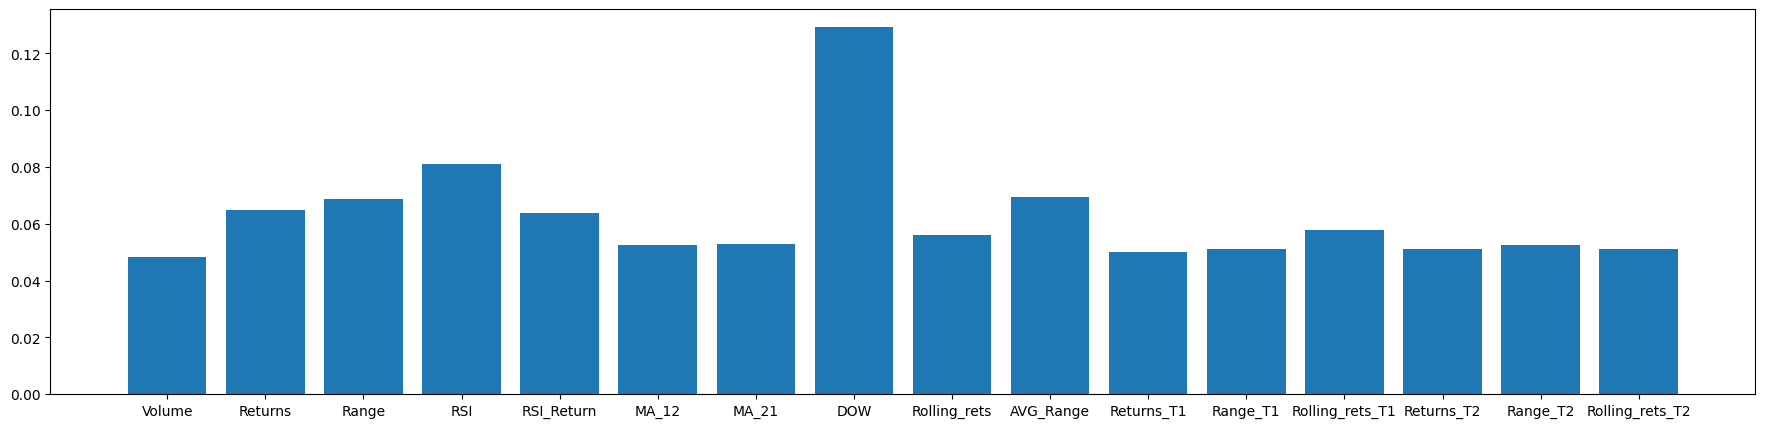

In [21]:
# RELEVANCY - features that influenced ai decisions 
fig = plt.figure(figsize=(22,5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels , importance_features)
plt.show()

In [22]:
# SELECT BEST FEATURES
mean_of_feature_importance = importance_features.mean()
recommended_feature_labels = []
recommended_feature_score = []
for i in range(0, len(importance_features) , 1) :
    if importance_features[i] > mean_of_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(importance_features[i])


# save output for future reference
with open('./data/feature_selection_output.json', 'w') as f:
    json.dump(recommended_feature_labels, f)

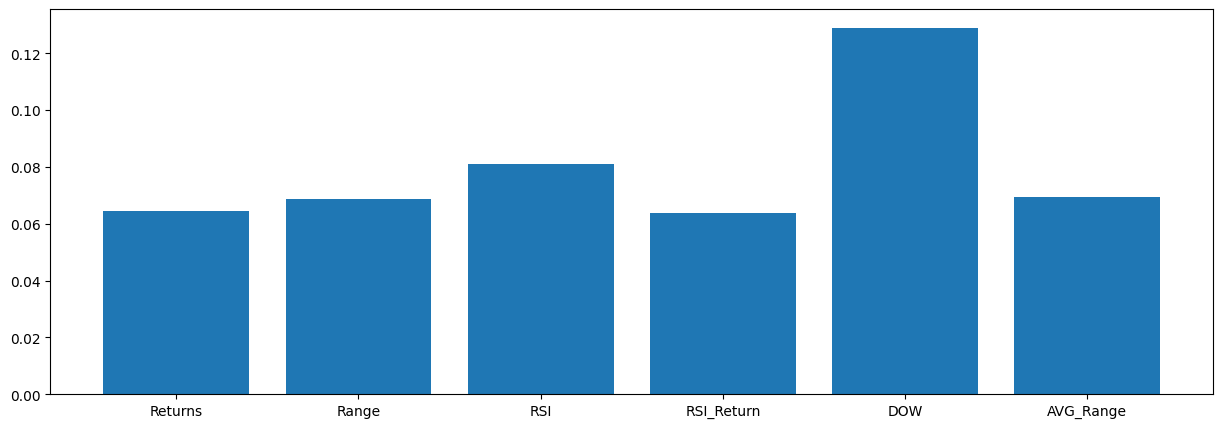

In [23]:
# plot recommended features
fig = plt.figure(figsize=(15,5))
plt.bar(recommended_feature_labels , recommended_feature_score)
plt.show()

*These features had the most influence on the ai*